In [2]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions
using Test

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1342
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broke

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

In [3]:
using Plots
using LaTeXStrings

In [5]:
function routine_plot(state::Vector{Float64}, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = cylinder_state_to_lagrange(state, config)
    Z = X .+ im*Y'
    ψ = imag.(LowRankVortex.F(Z, source))
    
    plt = plot(collect(X), collect(Y), ψ', ratio = 1.0, colorbar = false, 
                      xlim = (X[1], X[end]), 
                      ylim = (Y[1], Y[end]); levels = 10)
    
        
    θc = range(0,2π,length=201)
    zc = exp.(im*θc[1:end-1])
    plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
    
    if withvortices == true
        plot!(plt, source, markersize = 4, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

routine_plot(blobs, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true) = 
routine_plot(cylinder_lagrange_to_state(blobs, config), config, X, Y; withvortices=withvortices)


routine_plot (generic function with 2 methods)

### Configuration setup

In [306]:
# grid for evaluation
xgrid = range(-4,4,length=201)
ygrid = copy(xgrid)
zgrid = xgrid .+ im*ygrid';

# sensors on the unit circle
θsensors = range(0,2π,length=31)[1:end-1]
sensors = exp.(im*θsensors)

t0 = 0.0
tf = 1.0
tspan = (t0, tf)

# create configuration file
config_data = let Nv = 8, U = complex(0.0), 
             ss = sensors, Δt = 5e-3, δ = 1e-3,
             ϵX = 1e-2, ϵΓ = 1e-2,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

Ny = length(config_data.ss)
Nx = 3*config_data.Nv

24

### Generate the truth used in the twin experiment

In [307]:
σθ = 0.05*(2*π/(config_data.Nv))
θv = range(0,2π,length=config_data.Nv+1)[1:end-1] .+ σθ*randn(config_data.Nv)

r0 = 3.0
σr = 0.05*r0
rv = r0 .+ σr*randn(config_data.Nv)

Γ0 = 10.0
σΓ = 0.05*Γ0
zv = rv .* exp.(im*θv)
Γv = Γ0 .+ σΓ*randn(config_data.Nv)

blobs = Vortex.Blob.(zv,Γv,config_data.δ*ones(config_data.Nv))

data = generate_data_cylinder_twin_experiment(deepcopy(blobs), t0, tf, config_data,
       "/media/mat/HDD/LowRankVortex.jl/localization/")

tt, x0, xt, yt = load("/media/mat/HDD/LowRankVortex.jl/localization/data_cylinder_twin_experiment.jld", 
                      "tt", "x0", "xt", "yt")
data = SyntheticData(tt, config_data.Δt, x0, xt, yt)

SyntheticData([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045  …  0.9550000000000001, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1.0], 0.005, [3.1513961322709347, 0.02322744114476053, 10.436748104529766, 2.0059122621976515, 2.0834229423012234, 10.032071161406533, 0.10355736310725017, 2.850300496149108, 10.535164057434972, -2.321710487860722  …  9.778379783167882, -2.1259870772390257, -2.1344292539060863, 10.206378031179486, -0.1381724348446786, -3.2199527408919595, 9.060955065780044, 2.1388894154224465, -2.0021349772088866, 9.362390167062054], [3.1587354899952156 3.14664553603013 … 2.6040550422380626 2.60073380155731; 0.015255620596800884 0.04108135041605655 … 2.0782477112554067 2.1007577424787565; … ; -1.9799655015753312 -1.9944459834969859 … -0.4383903923916844 -0.4312897092822268; 9.372660853938326 9.354233242125925 … 9.420948936088438 9.424364814488614], [-7.729049030420318 -7.75991165628554 … -7.639519235953618 -7.6466199525892815; -7.79666993555627 -7.832

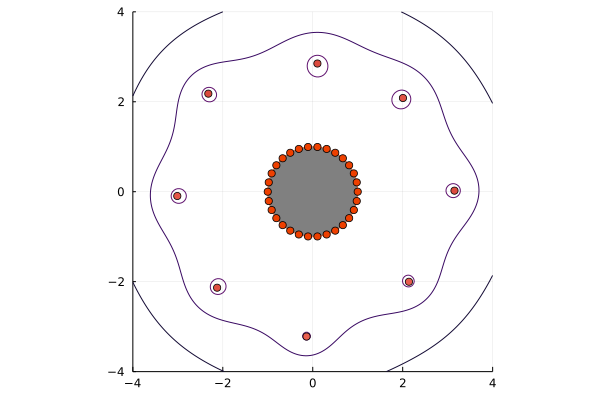

In [308]:
routine_plot(blobs, config_data, xgrid, ygrid)

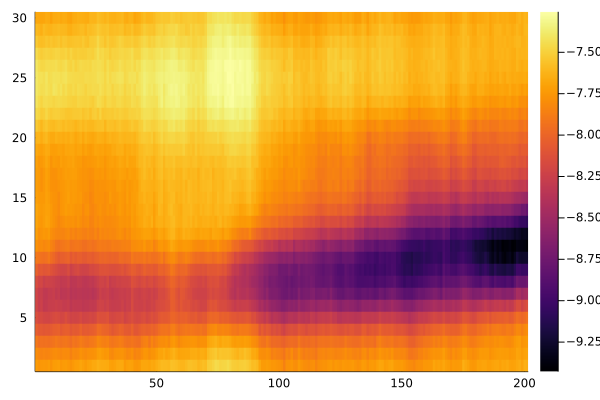

In [309]:
heatmap(data.yt)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
┌ Info: Saved animation to 
│   fn = /media/mat/HDD/LowRankVortex.jl/localization/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/media/mat/HDD/LowRankVortex.jl/localization/tmp.gif")
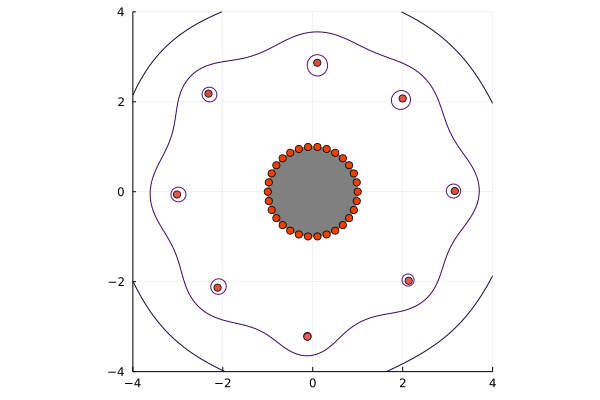

In [310]:
## Make movie animation
Δtgif = 1e-2
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt = routine_plot(data.xt[:,nsnap], config_data, xgrid, ygrid)
    next!(prog)
end

### Setup of the ensemble filter

In [311]:
config = deepcopy(config_data)

VortexConfig(8, 0.0 + 0.0im, ComplexF64[1.0 + 0.0im, 0.9781476007338057 + 0.20791169081775931im, 0.9135454576426009 + 0.40673664307580015im, 0.8090169943749475 + 0.5877852522924731im, 0.6691306063588582 + 0.7431448254773941im, 0.5000000000000001 + 0.8660254037844386im, 0.30901699437494745 + 0.9510565162951535im, 0.10452846326765368 + 0.9945218953682733im, -0.10452846326765333 + 0.9945218953682734im, -0.30901699437494734 + 0.9510565162951536im  …  -0.5000000000000004 - 0.8660254037844385im, -0.30901699437494756 - 0.9510565162951535im, -0.10452846326765423 - 0.9945218953682733im, 0.10452846326765299 - 0.9945218953682734im, 0.30901699437494723 - 0.9510565162951536im, 0.49999999999999933 - 0.866025403784439im, 0.6691306063588578 - 0.7431448254773946im, 0.8090169943749473 - 0.5877852522924734im, 0.9135454576426005 - 0.40673664307580093im, 0.9781476007338056 - 0.20791169081775987im], 0.005, 0.001, 0.01, 0.01, 1.0, 0.01)

In [312]:
ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

senkf = StochEnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = false)
lrenkf = LREnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = false)

LREnKF  with filtered = false


In [313]:
# Generate the initial condition

Ne = 30

X0 = zeros(Ny+Nx, Ne)


for i=1:Ne
    θi = range(0,2π,length=config_data.Nv+1)[1:end-1] .+ σθ*randn(config_data.Nv)
    ri = r0 .+ σr*randn(config_data.Nv)
    zi = ri .* exp.(im*θi)
    Γi = Γ0 .+ σΓ*randn(config_data.Nv)
    
    bi = Vortex.Blob.(zi,Γi,config_data.δ*ones(config_data.Nv))
    X0[Ny+1:Ny+Nx,i] = cylinder_lagrange_to_state(bi, config_data)
end

X = deepcopy(X0);

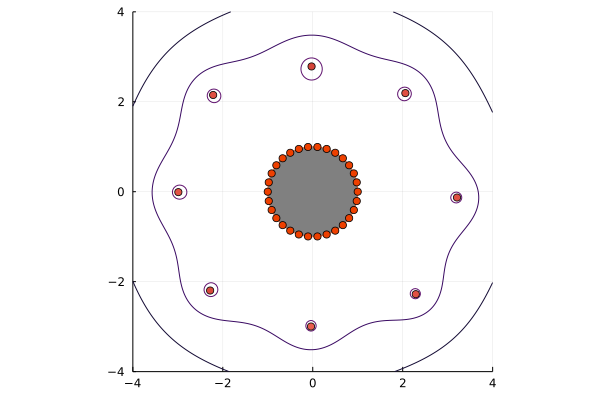

In [314]:
routine_plot(X[Ny+1:Ny+Nx,1], config_data, xgrid, ygrid)

In [315]:
@time Xf, Xa = senkf_cylinder_vortexassim(senkf, deepcopy(X0), tspan, config, data; P = serial)
# save("ensemble_Ne_"*string(Ne)*"_2.jld", "Xf", Xf, "Xa", Xa)

rmse_enkf = mean(norm.(eachcol(mean_hist(Xa)-data.xt))/sqrt(size(data.x0,1)))

  2.853346 seconds (1.75 M allocations: 419.004 MiB, 2.79% gc time)


0.5278303165244409

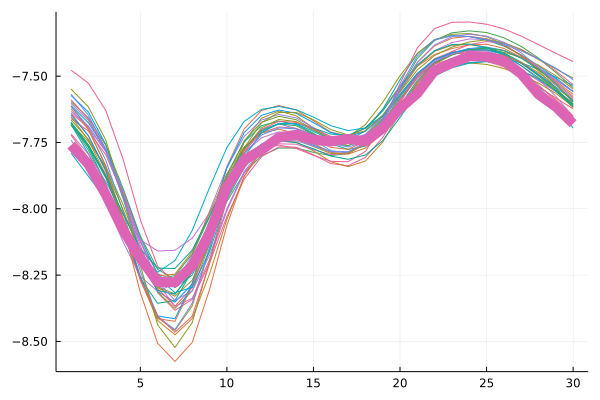

In [316]:
plt = plot(legend = false)
for i=1:Ne
    plot!(plt, h(Xa[2][:,i],0.0))
end
plt

plot!(plt, data.yt[:,2], linewidth = 10)
plt

In [317]:
norm(mean(X0[Ny+1:Ny+Nx,:]; dims = 2)[:,1]-data.xt[:,1])

1.5863110651567272

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
┌ Info: Saved animation to 
│   fn = /media/mat/HDD/LowRankVortex.jl/localization/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/media/mat/HDD/LowRankVortex.jl/localization/tmp.gif")
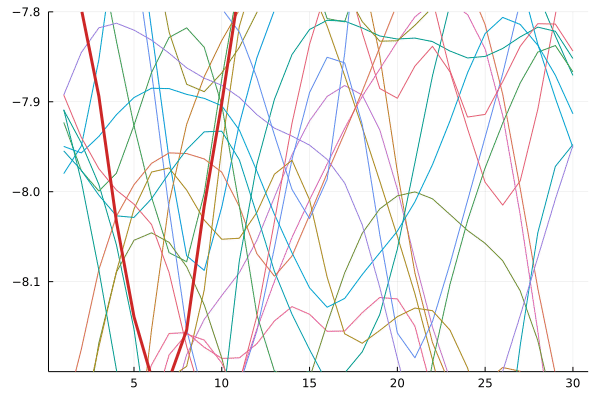

In [321]:
## Make movie animation
Δtgif = 1e-2
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt = plot(legend = false, ylim = (-8.20, -7.8))
    for i=1:Ne
        plot!(plt, h(Xa[nsnap][:,i],0.0))
    end
    plot!(plt, data.yt[:,nsnap], linewidth = 3, color = colorant"firebrick3")
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
┌ Info: Saved animation to 
│   fn = /media/mat/HDD/LowRankVortex.jl/localization/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/media/mat/HDD/LowRankVortex.jl/localization/tmp.gif")
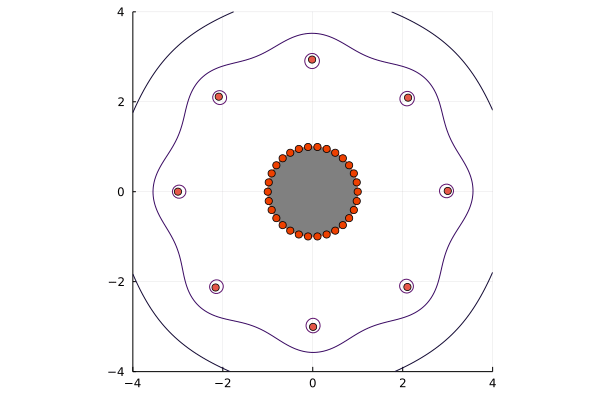

In [322]:
## Make movie animation
Δtgif = 1e-2
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt = routine_plot(mean(Xa[nsnap]; dims = 2)[:,1], config_data, xgrid, ygrid)
    next!(prog)
end

In [323]:
J = zeros(length(config_data.ss), Nx)

@time for i=1:config_data.Nv
    dpdzi = dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[1][:,1], config_data))
    J[:,3*i-2] .= 2*real(dpdzi)  
    J[:,3*i-1] .= -2*imag(dpdzi)
    
    dpdΓi = dpdΓv(config_data.ss, i, cylinder_state_to_lagrange(Xf[1][:,1], config_data))
    J[:,3*i] .= dpdΓi
end

  0.002487 seconds (266 allocations: 35.875 KiB)


In [324]:
U, Λ, V = svd(J);

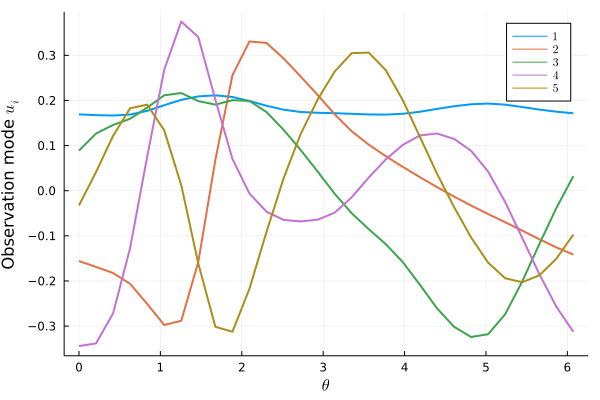

In [325]:
plt = plot(xlabel = L"\theta", ylabel = "Observation mode "*L"u_i")

for i=1:5
    plot!(plt, θsensors, U[:,i], linewidth = 2, label = latexstring(i))
end
#scatter!(plt, θsensors, zero(θsensors), markersize = 5)

plt

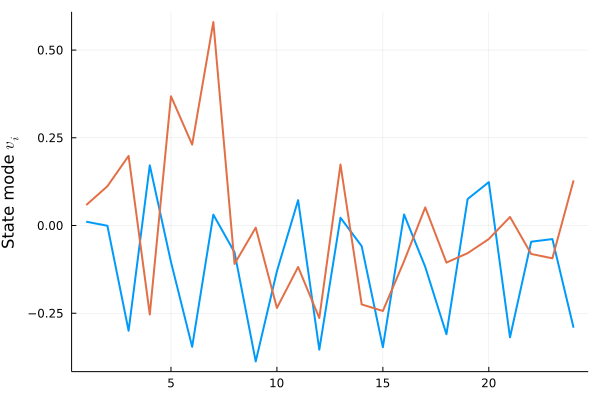

In [327]:
plt = plot(ylabel = "State mode "*L"v_i", legend = false)

for i=1:2
    plot!(plt, V[:,i], linewidth = 2)
end
plt

In [328]:
Cy = J*J'
Λy = sqrt.(svd(Cy).S)
cumsum((Λy.^2)./sum(Λy.^2))

30-element Vector{Float64}:
 0.6371581916441084
 0.749851769760079
 0.8470286550939745
 0.9100046318850188
 0.9601700943668993
 0.9772430335151427
 0.9919315757838494
 0.995830636564806
 0.9985140650341704
 0.9996727253878257
 0.9998666512289563
 0.9999271377535084
 0.999969244785917
 ⋮
 0.9999999258178884
 0.9999999623859941
 0.9999999886817545
 0.9999999981521406
 0.9999999998175886
 0.9999999999999994
 0.9999999999999996
 0.9999999999999996
 0.9999999999999996
 0.9999999999999997
 0.9999999999999998
 0.9999999999999998

In [329]:
Cx = J'*J
Λx = sqrt.(svd(Cx).S)
cumsum((Λx.^2)./sum(Λx.^2))

24-element Vector{Float64}:
 0.6371581916441086
 0.7498517697600793
 0.8470286550939747
 0.9100046318850191
 0.9601700943668996
 0.9772430335151432
 0.9919315757838498
 0.9958306365648064
 0.9985140650341708
 0.9996727253878261
 0.9998666512289568
 0.9999271377535088
 0.9999692447859174
 0.9999860533136774
 0.9999948061447945
 0.9999972114301731
 0.9999988622817191
 0.9999997123758451
 0.9999999258178889
 0.9999999623859945
 0.999999988681755
 0.999999998152141
 0.999999999817589
 0.9999999999999999

In [330]:
(cumsum(Λ.^2)./sum(Λ.^2))

24-element Vector{Float64}:
 0.6371581916441085
 0.7498517697600793
 0.8470286550939748
 0.9100046318850192
 0.9601700943668999
 0.9772430335151434
 0.9919315757838499
 0.9958306365648066
 0.9985140650341711
 0.9996727253878264
 0.999866651228957
 0.999927137753509
 0.9999692447859176
 0.9999860533136775
 0.9999948061447946
 0.9999972114301732
 0.9999988622817192
 0.9999997123758453
 0.999999925817889
 0.9999999623859946
 0.9999999886817552
 0.9999999981521411
 0.9999999998175891
 1.0

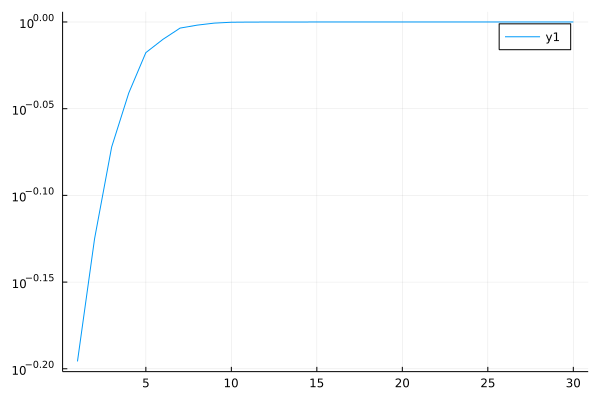

In [331]:
plot(cumsum(Λy.^2)./sum(Λy.^2), yscale = :log10)

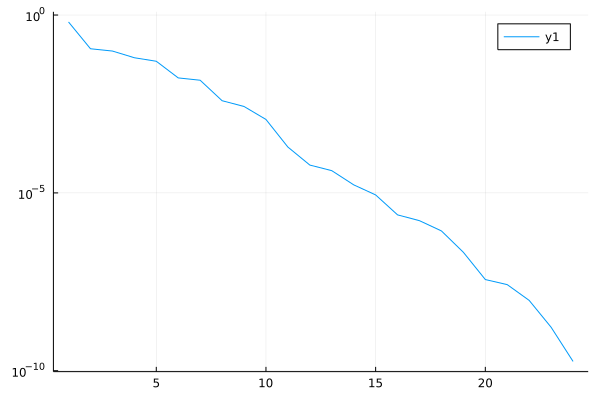

In [332]:
plot((Λ.^2)./sum(Λ.^2), yscale = :log10)

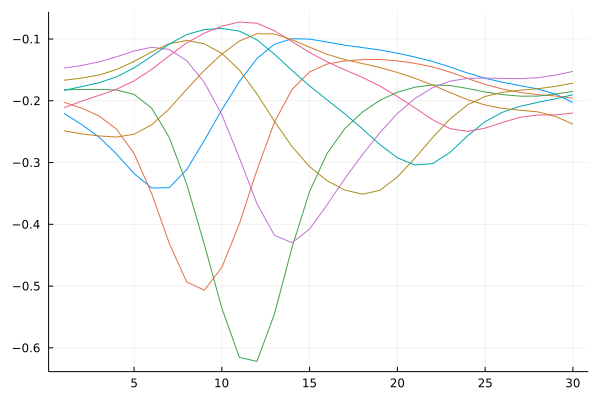

In [333]:
plt = plot(legend = false)

for i=1:config_data.Nv
    #plot!(plt, real(dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))))
    #plot!(plt, imag(dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))))
    plot!(plt, dpdΓv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data)))
end
plt

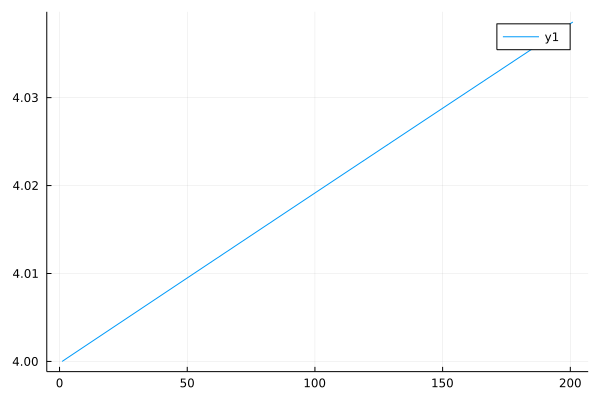

In [23]:
plot(map(xi -> xi[1]^2 + xi[2]^2, Xf))

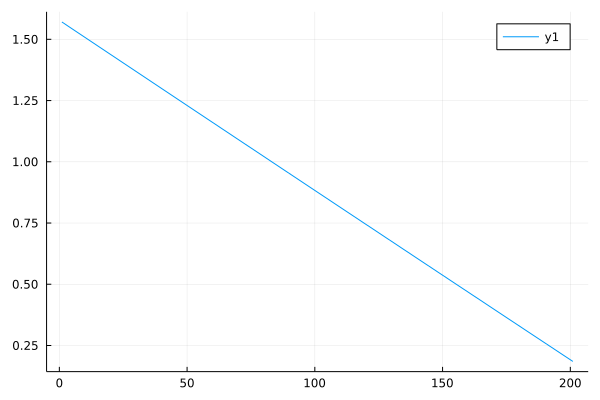

In [24]:
plot(map(xi -> atan(xi[1], xi[2]), Xf))

In [25]:
-ΓJ/(4*π^2*(abs2(zJ)*(abs2(zJ)-1)))

-0.626347670570229

In [26]:
10-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(1.5524030608054593 + 1.4966356498690878im, 1.777087057229044, 1.0e-7)
 Vortex.Blob(0.30297956811366955 - 1.5310233453394266im, 2.9950386389152985, 1.0e-7)
 Vortex.Blob(1.9533834668703678 + 1.5266552994597413im, 1.2339447083625958, 1.0e-7)
 Vortex.Blob(-1.0513133042403213 - 1.8227794557170132im, 1.6223707566499805, 1.0e-7)
 Vortex.Blob(-1.0836095985941654 + 0.7843079480127662im, 1.2450142628958365, 1.0e-7)
 Vortex.Blob(1.3467972420595151 + 0.7119955880276292im, 2.3945872015751033, 1.0e-7)
 Vortex.Blob(-1.543405087720262 - 0.948819867733115im, 2.391208846205823, 1.0e-7)
 Vortex.Blob(1.7504807284205954 - 1.4213977275321987im, 1.3496791100069796, 1.0e-7)
 Vortex.Blob(-1.2616569955408155 + 0.3668878315302502im, 1.7170363502434927, 1.0e-7)
 Vortex.Blob(0.9089535560506601 - 1.9950164010242206im, 1.6791417364879595, 1.0e-7)

LoadError: syntax: extra token "Vector" after end of expression